# Recurrent Neural Networks : Long Short Term Memory networks (LSTM)

We have already covered feed-forward neural networks during the computer vision and the recommended system module. For natural language processing, one type of popular deep learning architecture is called Reccurent Neural Networks (RNNs). RNNs differ from feed-forward networks in the sense that some of their inner layers are recursively updated while iterating over the sequence of words given in input. We are going to use one specific RNN architecture called Long-Short Term Memory networks (LSTMs), which have been especially successful in various NLP tasks, including automatic translation, question answering, ... and text classification, our case study in this module.

Learn more about how RNNs and LSTMs encode texts as vectors first:

https://medium.com/towards-data-science/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9

If you want to understand in depth how one LSTM cell is working, you can go through these two articles:

https://medium.com/towards-data-science/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

http://colah.github.io/posts/2015-08-Understanding-LSTMs/


# **Qu’est-ce qu’un LSTM ?** #

Un LSTM (Long Short-Term Memory) est un type de réseau de neurones récurrent (RNN) spécialement conçu pour traiter des données séquentielles, comme du texte. Contrairement aux RNN classiques, les LSTM sont capables de conserver de l’information sur de longues distances, ce qui les rend efficaces pour modéliser le contexte linguistique dans une phrase.

Dans le cadre du NLP, un LSTM lit une phrase mot par mot, dans l’ordre, et apprend à capturer les dépendances entre les mots. Cela lui permet de comprendre des constructions comme “not good” ou “despite the bad acting, the story was great”, ce que les approches Bag-of-Words ne capturent pas.


### Fonctionnement général ###

Un LSTM maintient deux types d’états internes à chaque pas de temps :           
- le state caché ht : ce que le réseau “retient” à l’instant t          
- le state mémoire ct : la “mémoire longue durée” du réseau         

Lorsqu’un mot est lu, le LSTM met à jour ces deux états en fonction :       
    - du mot courant        
    - de la mémoire accumulée       
    - et de portes (gates) apprises pendant l’entraînement      


### Le point de vue mathématique (simple et clair) ###


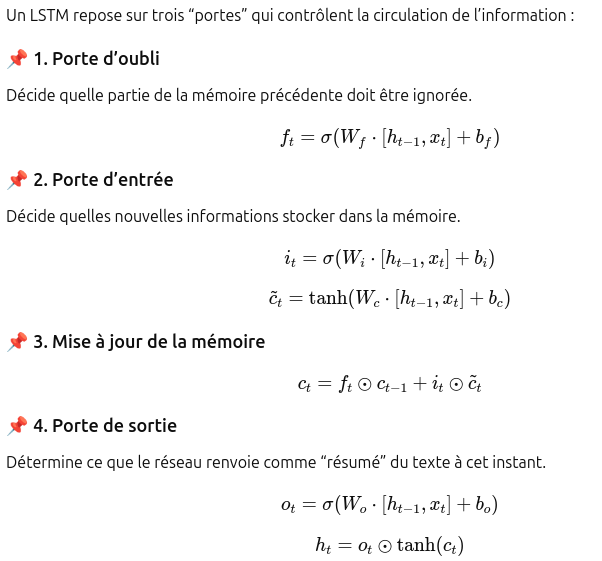


### Intuition ### 

Les portes apprennent à décider quoi retenir, quoi oublier, et quoi sortir.

Grâce à cela, un LSTM peut conserver des informations importantes sur plusieurs mots, voire plusieurs phrases.

Par exemple, dans “The movie was not good but the acting saved it”, le LSTM peut préserver le contexte même si les mots sont éloignés.


### Rôle dans la classification de sentiments ###

Dans le modèle ci-après :       
- Une couche Embedding transforme chaque mot en un vecteur dense (sémantique).          
- Le LSTM lit la séquence de mots et produit une représentation du texte entier.       
- Une couche Dense + Sigmoid transforme cette représentation en probabilité (positif / négatif).

Ainsi, un LSTM ne fait pas que compter des mots : il comprend l’ordre, le contexte et les relations entre les mots.


### **En résumé** ###

Un LSTM est un réseau récurrent capable de gérer les dépendances longues.       
Il utilise des portes pour contrôler ce qu’il garde en mémoire.         
Il est beaucoup plus puissant que BOW/TF-IDF parce qu’il exploite l’ordre des mots.         
En classification de sentiments, il apprend des représentations riches du texte.            

## Load Data

In [4]:
outdir = '../data/imdb_clean/'

In [5]:
import pandas as pd
import numpy as np
train_deep_clean = pd.read_csv(outdir + 'train.csv')
valid_deep_clean = pd.read_csv(outdir + 'valid.csv')
test_deep_clean = pd.read_csv(outdir + 'test.csv')

## Implementing LSTMs with Keras

In [6]:
#Some lines that allow for faster training with this version of tensorflow for these models
import tensorflow as tf
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

2.19.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
import keras
from keras.layers import TextVectorization
from keras.models import Sequential
from keras.layers import *

We will use Keras to implement an LSTM network. First we need to encode all the reviews as a list of indexes, where each word is replaced by its embedding index using keras `TextVectorization` object. To make all training reviews the same size, the `TextVectorization` will add a special token < pad > (encoded as 0) as many time as necessary to each text to match the length of the longest text. This token will be ignored by the LSTM layer.

In [8]:
max_vocab_size = 10000 

vectorizer = TextVectorization(max_tokens=max_vocab_size, output_mode='int',split='whitespace')
vectorizer.adapt(pd.concat([train_deep_clean,valid_deep_clean]).review)

# This encodes our sentence as a sequence of integer
# each integer being the index of each word in the vocabulary
# Zeros are added at the end so that each text has the same length
train_seqs = vectorizer(train_deep_clean.review)
valid_seqs = vectorizer(valid_deep_clean.review)
test_seqs = vectorizer(test_deep_clean.review)

max_seq_length = train_seqs.shape[1]

#However due to a bug in Keras 3, we need to put the zeros at the beginning, not at the end:
def repad_left(x, maxlen):       
    rows = []
    x_arr = np.array(x)
    x_arr = np.concatenate((x_arr, np.zeros((x_arr.shape[0],1))), axis=1)
    for row in x_arr:
        rows.append(row[:row.argmin()])
    ledt_padded_x = keras.utils.pad_sequences(rows, maxlen=maxlen)
    return ledt_padded_x
        

X_train = repad_left(train_seqs, max_seq_length)
X_valid = repad_left(valid_seqs, max_seq_length)
X_test = repad_left(test_seqs, max_seq_length)

#Finally we encode the ys :
y_train = pd.get_dummies(train_deep_clean.sentiment).values[:,1]
y_valid = pd.get_dummies(valid_deep_clean.sentiment).values[:,1]
y_test = pd.get_dummies(test_deep_clean.sentiment).values[:,1]


Now fill the following function to implement a simple LSTM model : one embedding layer, one LSTM layer, and a final dense layer that yields a single score with a sigmoid activation function. Use Keras' Sequential API.

In [6]:
def get_lstm_model(vocab_size, embedding_dim, seq_length, lstm_out_dim):
    # Sequential model
    model = Sequential()

    # Embedding layer => transforme les indices de mots en vecteurs denses
    model.add(Embedding(
        input_dim = vocab_size,      # taille du vocabulaire
        output_dim = embedding_dim,  # dimension des embeddings
        input_length = seq_length    # longueur des séquences en entrée, on peut l'enlever car deprecated
    ))    
    
    # LSTM : lit la séquence et produit une représentation du texte
    model.add(LSTM(lstm_out_dim))
    
    # couche de sortie : 1 neurone avec sigmoid pour une proba [0,1]
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer='SGD',metrics = ['accuracy'])
    return model

In [7]:
embedding_dim = 100
lstm_out_dim = 200  #Bigger than embedding dim, as it combines all the words of each review

model_lstm = get_lstm_model(max_vocab_size, embedding_dim, max_seq_length, lstm_out_dim)

# On envoie un batch bidon de 1 séquence de max_seq_length tokens 
# pour que keras infère toutes les tailles et crée les poids pour que le sumamry devient complet
dummy_input = np.zeros((1, max_seq_length), dtype="int32")
_ = model_lstm(dummy_input)   # construit le modèle

print(model_lstm.summary())

/home/marie.vanacker@Digital-Grenoble.local/anaconda3/envs/keras_gpu/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-12-03 12:56:22.202483: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 2459, 100)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (1, 200)               │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 1)                 │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,241,001 (4.73 MB)

 Trainable params: 1,241,001 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
batch_size = 64
max_epochs = 2
history_lstm = model_lstm.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, 
                    verbose=1, validation_data = (X_valid, y_valid))

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 223ms/step - accuracy: 0.4963 - loss: 0.6931 - val_accuracy: 0.5176 - val_loss: 0.6930
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 226ms/step - accuracy: 0.5088 - loss: 0.6930 - val_accuracy: 0.4918 - val_loss: 0.6932


In [9]:
test_acc_lstm = model_lstm.evaluate(X_test, y_test, verbose=0) 
print("Test accuracy: %.2f%%" % (test_acc_lstm[1]*100))

Test accuracy: 50.00%


Pretty low accuracy isn't it ? Actually it is very easy to incorrectly train a deep neural net. Change the optimizer with "adam" instead of "SGD", add a dropout layer after the LSTM layer for regularization, and use early stopping :

In [10]:
from keras.layers import Embedding, LSTM, Dense, Dropout

#dropout, early stopping, adam
def get_lstm_model_2(vocab_size, embedding_dim, seq_length, lstm_out_dim, dropout_rate):
    # Sequential model
    model = Sequential()

    # Embedding layer => transforme les indices de mots en vecteurs denses
    model.add(Embedding(
        input_dim = vocab_size,      # taille du vocabulaire
        output_dim = embedding_dim,  # dimension des embeddings
        input_length = seq_length    # longueur des séquences en entrée
    ))    
    
    # LSTM : lit la séquence et produit une représentation du texte
    model.add(LSTM(lstm_out_dim))
    
    # Dropout après LSTM pour la régularisation
    model.add(Dropout(dropout_rate))
    
    # couche de sortie : 1 neurone avec sigmoid pour une proba [0,1]
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

    

In [11]:
embedding_dim = 100
lstm_out_dim = 200
dropout_rate = 0.2

model_lstmDrop = get_lstm_model_2(max_vocab_size, embedding_dim, max_seq_length, lstm_out_dim, dropout_rate)

# On envoie un batch bidon de 1 séquence de max_seq_length tokens 
# pour que keras infère toutes les tailles et crée les poids pour que le sumamry devient complet
dummy_input = np.zeros((1, max_seq_length), dtype="int32")
_ = model_lstmDrop(dummy_input)   # construit le modèle

print(model_lstmDrop.summary())

/home/marie.vanacker@Digital-Grenoble.local/anaconda3/envs/keras_gpu/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (1, 2459, 100)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (1, 200)               │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 200)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,241,001 (4.73 MB)

 Trainable params: 1,241,001 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,              # on arrête si la val_loss n’améliore plus pendant 2 epochs
    restore_best_weights=True
)

In [13]:
batch_size = 32
max_epochs = 5
history_lstmDrop= model_lstmDrop.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, 
                    verbose=1, validation_data = (X_valid, y_valid), callbacks=[early_stopping])


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 138ms/step - accuracy: 0.7023 - loss: 0.5762 - val_accuracy: 0.7194 - val_loss: 0.5401
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.8081 - loss: 0.4281 - val_accuracy: 0.8224 - val_loss: 0.4119
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.8635 - loss: 0.3309 - val_accuracy: 0.7746 - val_loss: 0.4829
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.9105 - loss: 0.2319 - val_accuracy: 0.8740 - val_loss: 0.2994
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.9413 - loss: 0.1616 - val_accuracy: 0.8856 - val_loss: 0.3072


In [14]:
test_acc_lstmDrop = model_lstmDrop.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: %.2f%%" % (test_acc_lstmDrop[1]*100))

Test accuracy: 86.36%


Much better. If we'd run for a longer time, we'd get a bit better results from our classic methods, but that's still quite slow for little improvement. We could also grid search for all hyper parameters (embedding and layer sizes, dropout rate, ...), but that's not the goal today, remember however that grid-search is standard when optimizing a model predictive performances.

### **Pourquoi Adam, Dropout et EarlyStopping améliorent le LSTM ?** ###

Le premier modèle LSTM entraîné avec l’optimizer SGD a obtenu une accuracy proche de 50%, ce qui correspond pratiquement à du hasard. Cela s’explique par le fait qu’un réseau profond comme un LSTM est difficile à optimiser : il nécessite un optimiseur plus performant, ainsi que de la régularisation pour éviter le surapprentissage.

**✔️ Optimizer : Adam au lieu de SGD**

L’optimizer Adam ajuste automatiquement la vitesse d’apprentissage pour chaque poids du réseau.
Il converge plus rapidement et de manière plus stable que SGD, surtout pour des modèles séquentiels comme les LSTM.
Grâce à cela, le réseau apprend réellement des structures linguistiques et ne reste pas bloqué dans une solution aléatoire.

**✔️ Dropout : empêcher l’overfitting**

Un LSTM sans régularisation mémorise trop facilement le jeu d’entraînement, ce qui conduit à un fort overfitting.
L’ajout d’une couche Dropout après le LSTM désactive aléatoirement une fraction des neurones pendant l’entraînement.
Cela oblige le réseau à apprendre des représentations plus robustes et améliore la performance sur les données de validation et test.

**✔️ EarlyStopping : arrêter au bon moment**

Sans mécanisme d’arrêt anticipé, un réseau profond continue d’apprendre même après avoir commencé à sur-apprendre le bruit du jeu d’entraînement.
La technique EarlyStopping surveille la perte de validation et interrompt automatiquement l’entraînement lorsqu’elle cesse de s’améliorer.
Avec restore_best_weights=True, le modèle final correspond à la meilleure epoch observée.

## Predict sentiment for arbitrary sentences

Now you can try predict the sentiment of any kind of sentence in english, try your own. You first need to encode each review as a sequence of indexes (called tokens in keras), to pad these sequances, and finally predict the score with your trained model:

In [15]:
good = "i really liked the movie and had fun"
bad = "worst movie on the planet , so boring"
for review in [good,bad]:
    
    #on encore de texte
    seq = vectorizer ([review]) # shape (1,seq_len)
    
    # repad à gauche comme pour le train/valid/test
    seq_padded = repad_left (seq, max_seq_length)
    
    # prédire avec le modèle lstm entrainé
    proba = model_lstmDrop.predict (seq_padded) [0,0] # proba d'être "positif"
    
    sentiment = "positive" if proba >= 0.5 else "negative"
    
    print(f"Review : {review}")
    print(f"Predicted probability (positive): {proba:.3f} → {sentiment}\n")
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Review : i really liked the movie and had fun
Predicted probability (positive): 0.810 → positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Review : worst movie on the planet , so boring
Predicted probability (positive): 0.005 → negative



Une fois la phrase encodée en séquence d’indices avec `TextVectorization`, sa longueur est variable.  
Or, notre LSTM a été entraîné sur des séquences de longueur fixe `max_seq_length`, avec des zéros ajoutés au **début** des séquences (padding à gauche) à cause d’un bug de Keras 3.

La fonction `repad_left` :
1. enlève d’abord les zéros inutiles en fin de séquence ;
2. réapplique un padding à gauche pour obtenir une séquence de longueur `max_seq_length`.

Ainsi, lors de la prédiction :

```python
seq = vectorizer([review])
seq_padded = repad_left(seq, max_seq_length)
proba = model.predict(seq_padded)


## Initialize embeddings with pre-trained word embeddings

The training of LSTMs is a bit heavy, one way to speed this up is to re-use pre-trained word embeddings. Many such embeddings are available on the net. Read this to understand how are produced word embeddings and why they encode information that helps with all NLP tasks:

http://jalammar.github.io/illustrated-word2vec/

We are going to use GloVe embeddings, download and load the embeddings produced from 6 billions documents from : https://nlp.stanford.edu/projects/glove/

### **Word embeddings et GloVe** ###

Jusqu’ici, les mots étaient représentés soit par des indices entiers (via TextVectorization), soit implicitement via des one-hot / TF-IDF.
Ces représentations sont sparse (très grandes dimensions, beaucoup de zéros) et ne capturent pas la similarité sémantique entre les mots.

Les word embeddings sont une manière de représenter chaque mot par un vecteur dense de petite dimension (par exemple 100), appris de façon à ce que :

- des mots proches en sens aient des vecteurs proches (ex : good, great, excellent) ;

- des mots très différents aient des vecteurs éloignés.

On peut soit apprendre ces embeddings à partir de notre dataset, soit utiliser des embeddings pré-entraînés sur un grand corpus.
Ici, on utilise les embeddings pré-entraînés GloVe (glove.6B.100d), appris sur un grand corpus de textes en anglais.

On commence par charger le fichier GloVe et construire un dictionnaire :

In [9]:
embeddings_index = {}
f = open('../data/glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [10]:
word_index = {w : i for i,w in enumerate(vectorizer.get_vocabulary()) }

Puis, à partir de notre word_index (le vocabulaire appris sur le jeu de données), on construit une matrice embedding_matrix de taille :

(max_vocab_size,embedding_dim)

Chaque ligne i correspond au vecteur d’embedding du mot d’index i :     
- si le mot existe dans GloVe → on copie son vecteur pré-entraîné ;
- sinon → on lui affecte un vecteur aléatoire (qui sera affiné pendant l’entraînement).

In [18]:
print('%s unique words in vocabulary' % len(word_index))

10000 unique words in vocabulary


Given our word index, search for each of our 10000 most frequents words if they exist in the pretrained GloVe embeddings and assign them to their corresponding row index in the embedding matrix. If they don't exist in the GloVe embeddings, assign a random vector :

In [11]:
embedding_dim = 100

# Allocate the embeddings matrix
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))


for word, i in word_index.items():
    # on s'assure de rester dans la :limite max_vocab_size
    if i >= max_vocab_size:
        continue
    
    # on récupère le vecteur GloVe du mot s'il existe
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        #cas 1 : le mot est présent dans GloVe et on copie le vecteur pré-entrainé
        embedding_matrix[i] = embedding_vector
    else:
        #cas 2 : mot absent de GloVe et on initialise avec un vecteur aléatoire
        embedding_matrix[i] = np.random.normal(
            loc=0.0, scale=0.05, size=(embedding_dim,)
        )


Now change your LSTM model so that the embedding layer is initialized with the pretrained embeddings :

In [20]:
def get_lstm_model_pretrained_embs(vocab_size, embedding_dim, seq_length, 
                                   lstm_out_dim, dropout_rate, embedding_matrix):
    
    model = Sequential()
    
    model.add(Input(shape=(seq_length,)))
    
    # Embedding pré-entraînée (GloVe) + random pour les mots manquants
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=seq_length,
        weights=[embedding_matrix],  # on injecte la matrice GloVe
        trainable=True               # on laisse le modèle affiner les embeddings
    ))
    
    # LSTM
    model.add(LSTM(lstm_out_dim))
    
    # Dropout pour la régularisation
    model.add(Dropout(dropout_rate))
    
    # Couche de sortie : probabilité de sentiment positif
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilation du modèle
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [21]:
embedding_dim = 100
lstm_out_dim = 200
dropout_rate = 0.2

model_lstmPretrain = get_lstm_model_pretrained_embs(max_vocab_size, embedding_dim, max_seq_length, 
                                       lstm_out_dim, dropout_rate, embedding_matrix)



print(model_lstmPretrain.summary())

/home/marie.vanacker@Digital-Grenoble.local/anaconda3/envs/keras_gpu/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 2459, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,241,001 (4.73 MB)

 Trainable params: 1,241,001 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
batch_size = 64
max_epochs = 5
history_lstmPretrain = model_lstmPretrain.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, 
                    verbose=1, validation_data = (X_valid, y_valid), callbacks=[early_stopping])


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 227ms/step - accuracy: 0.7369 - loss: 0.5185 - val_accuracy: 0.8440 - val_loss: 0.3823
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 227ms/step - accuracy: 0.8566 - loss: 0.3426 - val_accuracy: 0.8460 - val_loss: 0.3499


In [23]:
test_acc_lstmPretrain = model_lstmPretrain.evaluate(X_test, y_test, verbose=0) 
print("Test accuracy: %.2f%%" % (test_acc_lstmPretrain[1]*100))

Test accuracy: 82.68%


### **Intérêt des embeddings pré-entraînés** ###

Utiliser des embeddings GloVe apporte plusieurs avantages :

Meilleur point de départ : le modèle n’a pas à redécouvrir tout seul que good est proche de great ou que movie est proche de film ;

Meilleure généralisation : même avec un dataset limité (comme IMDB), les embeddings capturent des relations linguistiques apprises sur un corpus beaucoup plus large ;

Convergence plus rapide : le réseau apprend plus vite, car la première couche a déjà une structure pertinente.

En résumé, la couche Embedding avec GloVe permet au LSTM de travailler directement sur une représentation sémantique des mots, plutôt que sur de simples indices entiers sans signification géométrique.

We can see that the validation accuracy indeed progressed faster during the first epochs. For this small dataset it is not an issue, but it can save hours of training on bigger ones. It also reached a higher accuracy, which is not always the case, especially on bigger datasets.

For more speed-up, at the expense of accuracy, let's fix the embeddings so that they are not trainable parameters of the model, meaning they won't be updated during training :

In [24]:
def get_lstm_model_pretrained_embs(vocab_size, embedding_dim, seq_length, 
                                   lstm_out_dim, dropout_rate, embedding_matrix,
                                    trainable_embeddings):
    model = Sequential()
    
    model.add(Input(shape=(seq_length,)))
    
    # Couche d'embedding pré-entraînée (GloVe)
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=seq_length,
        weights=[embedding_matrix],
        trainable=trainable_embeddings  # True ou False selon l’argument
    ))
    
    # LSTM
    model.add(LSTM(lstm_out_dim))
    
    # Dropout pour la régularisation
    model.add(Dropout(dropout_rate))
    
    # Couche de sortie (binaire)
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model    
    

In [25]:
embedding_dim = 100
lstm_out_dim = 200
dropout_rate = 0.2
trainable_embeddings = False

model_lstmPretrainGlove = get_lstm_model_pretrained_embs(max_vocab_size, embedding_dim, max_seq_length, 
                                       lstm_out_dim, dropout_rate, embedding_matrix, trainable_embeddings)
print(model_lstmPretrainGlove.summary())

/home/marie.vanacker@Digital-Grenoble.local/anaconda3/envs/keras_gpu/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 2459, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,241,001 (4.73 MB)

 Trainable params: 241,001 (941.41 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

None


Notice the change in the number of trainable parameters in the summary.

In [40]:
batch_size = 64
max_epochs = 5
history_PretrainGlove = model_lstmPretrainGlove.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, 
                    verbose=1, validation_data = (X_valid, y_valid), callbacks=[early_stopping])


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 218ms/step - accuracy: 0.6643 - loss: 0.6121 - val_accuracy: 0.7286 - val_loss: 0.5500
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 218ms/step - accuracy: 0.7655 - loss: 0.4943 - val_accuracy: 0.8546 - val_loss: 0.3492


In [53]:
test_acc_lstmPretrainGlove = model_lstmPretrainGlove.evaluate(X_test, y_test, verbose=0) 
print("Test accuracy: %.2f%%" % (test_acc_lstmPretrainGlove[1]*100))

Test accuracy: 71.46%


Pourquoi LSTM + GloVe fonctionne moins bien lorsque trainable=False ?

Les embeddings GloVe sont pré-entraînés sur un corpus généraliste (Wikipedia, Common Crawl).
Ils capturent des relations sémantiques globales mais ne sont pas optimisés pour la tâche de sentiment analysis.
En mettant trainable=False, le réseau est forcé d’utiliser ces vecteurs “tels quels”, sans pouvoir les adapter au style et au vocabulaire spécifiques d’IMDB (expressions familières, émotions, intensificateurs, négations, etc.).
Résultat : le modèle converge mal et la performance est inférieure.

Lorsque trainable=True, les embeddings sont fine-tunés pendant l’entraînement :
ils conservent la structure de GloVe mais apprennent les nuances spécifiques au sentiment.
C’est pourquoi les modèles BiLSTM + GloVe entraînables atteignent les meilleures performances.

By fixing the word embeddings, the training time shrunk a bit, but the validation accuracy is progressing more slowly and reaching a limit. Depending on the network architecture, the trade-off can be interesting, here not so much, just know this is a possibility.

# Going further

## Bidirectional and stacked LSTMs

LSTMs parse the text from left to right, but doing it also from right to left and concatening the two output vectors improved the results. These are called bidirectional LSTMs. It is also possible to stack multiple LSTM layers.

This image is a good illustration of how these two variants work:


https://www.researchgate.net/figure/Illustrations-for-basic-LSTMs-and-the-three-layer-stacked-LSTM-model-for-the-sequential_fig4_313115860

First modify your network to make a bidirectional LSTM :

In [28]:
def get_bilstm_model_pretrained_embs(vocab_size, embedding_dim, seq_length, 
                                     lstm_out_dim, dropout_rate, embedding_matrix,
                                    trainable_embeddings):
    model = Sequential()
    
    model.add(Input(shape=(seq_length,)))
    
    # Embedding pré-entraînée (GloVe)
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=seq_length,
        weights=[embedding_matrix],
        trainable=trainable_embeddings  # True ou False
    ))
    
    # LSTM bidirectionnel : on lit la séquence dans les deux sens
    model.add(Bidirectional(LSTM(lstm_out_dim)))
    
    # Dropout pour la régularisation
    model.add(Dropout(dropout_rate))
    
    # Couche de sortie binaire (sentiment)
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilation du modèle
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model
    

In [29]:
embedding_dim = 100
lstm_out_dim = 200
dropout_rate = 0.2

model_bilstmPretrain = get_bilstm_model_pretrained_embs(max_vocab_size, embedding_dim, max_seq_length, 
                                       lstm_out_dim, dropout_rate, embedding_matrix, True)

print(model_bilstmPretrain.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 2459, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 400)            │       481,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,482,001 (5.65 MB)

 Trainable params: 1,482,001 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
batch_size = 32
max_epochs = 5
history_bilstmPretrain = model_bilstmPretrain.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, 
                    verbose=1, validation_data = (X_valid, y_valid), callbacks=[early_stopping])


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 264ms/step - accuracy: 0.7591 - loss: 0.4965 - val_accuracy: 0.8604 - val_loss: 0.3355
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 167s 267ms/step - accuracy: 0.8813 - loss: 0.2922 - val_accuracy: 0.8978 - val_loss: 0.2561
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 262ms/step - accuracy: 0.9265 - loss: 0.1946 - val_accuracy: 0.8994 - val_loss: 0.2571
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 165s 264ms/step - accuracy: 0.9528 - loss: 0.1327 - val_accuracy: 0.8966 - val_loss: 0.2704


In [31]:
test_acc_bilstmPretrain = model_bilstmPretrain.evaluate(X_test, y_test, verbose=0) 
print("Test accuracy: %.2f%%" % (test_acc_bilstmPretrain[1]*100))

Test accuracy: 89.00%


In [32]:
# quelques exemples pour tester :
examples = [
    "i really liked the movie and had fun",
    "worst movie on the planet, so boring",
    "the plot was weak but the acting was amazing",
    "i fell asleep after 20 minutes",
    "one of the best movies i have ever seen",
    "the movie was not bad at all, actually pretty good"
]

for review in examples:
    # 1) encoder le texte → séquence d'indices
    seq = vectorizer([review])          # shape (1, seq_len_var)
    
    # 2) repad à gauche comme pour X_train / X_valid / X_test
    seq_padded = repad_left(seq, max_seq_length)  # shape (1, max_seq_length)
    
    # 3) prédire la probabilité de "positif"
    proba = model_bilstmPretrain.predict(seq_padded, verbose=0)[0, 0]
    
    sentiment = "positive 😀" if proba >= 0.5 else "negative 😞"
    
    print(f"Review: {review}")
    print(f"Predicted probability (positive): {proba:.3f} → {sentiment}")
    print("-" * 60)


Review: i really liked the movie and had fun
Predicted probability (positive): 0.907 → positive 😀
------------------------------------------------------------
Review: worst movie on the planet, so boring
Predicted probability (positive): 0.012 → negative 😞
------------------------------------------------------------
Review: the plot was weak but the acting was amazing
Predicted probability (positive): 0.338 → negative 😞
------------------------------------------------------------
Review: i fell asleep after 20 minutes
Predicted probability (positive): 0.119 → negative 😞
------------------------------------------------------------
Review: one of the best movies i have ever seen
Predicted probability (positive): 0.851 → positive 😀
------------------------------------------------------------
Review: the movie was not bad at all, actually pretty good
Predicted probability (positive): 0.273 → negative 😞
------------------------------------------------------------


Now try stacking multiple bidirectional LSTM layers, where the number of layers `n_layers` is a parameter of the function building the model :

In [92]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

def get_multilayer_bilstm_model_pretrained_embs(vocab_size, embedding_dim, seq_length, 
                                                lstm_out_dim, dropout_rate, embedding_matrix,
                                                trainable_embeddings, n_layers):
    
    model = Sequential()
    
    model.add(Input(shape=(seq_length,)))
    
    # Embedding pré-entraînée (GloVe)
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=seq_length,
        weights=[embedding_matrix],
        trainable=trainable_embeddings  # True ou False
    ))
    
    # Empilement de plusieurs couches BiLSTM
    for layer_idx in range(n_layers):
        # Toutes les couches sauf la dernière doivent renvoyer toute la séquence
        return_seq = (layer_idx < n_layers - 1)
        model.add(Bidirectional(
            LSTM(lstm_out_dim, return_sequences=return_seq)
        ))
    
    # Dropout pour la régularisation
    model.add(Dropout(dropout_rate))
    
    # Couche de sortie binaire
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilation
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [93]:
embedding_dim = 100
lstm_out_dim = 100
dropout_rate = 0.2
n_layers = 2

model_bilstmPretrainMultiLayer = get_multilayer_bilstm_model_pretrained_embs(max_vocab_size, embedding_dim, max_seq_length, 
                                       lstm_out_dim, dropout_rate, embedding_matrix, True, n_layers)

print(model_bilstmPretrainMultiLayer .summary())

/home/marie.vanacker@Digital-Grenoble.local/anaconda3/envs/keras_gpu/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 2459, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 2459, 200)      │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,401,801 (5.35 MB)

 Trainable params: 1,401,801 (5.35 MB)

 Non-trainable params: 0 (0.00 B)

None


In [94]:
batch_size = 32
max_epochs = 5
history_bilstmPretrainMultiLayer  = model_bilstmPretrainMultiLayer .fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, 
                    verbose=1, validation_data = (X_valid, y_valid), callbacks=[early_stopping])


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 414ms/step - accuracy: 0.7776 - loss: 0.4615 - val_accuracy: 0.8718 - val_loss: 0.3194
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 259s 415ms/step - accuracy: 0.8954 - loss: 0.2662 - val_accuracy: 0.9024 - val_loss: 0.2538
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 413ms/step - accuracy: 0.9338 - loss: 0.1794 - val_accuracy: 0.8990 - val_loss: 0.2519
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 412ms/step - accuracy: 0.9574 - loss: 0.1228 - val_accuracy: 0.8992 - val_loss: 0.3158
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 413ms/step - accuracy: 0.9753 - loss: 0.0777 - val_accuracy: 0.8918 - val_loss: 0.4070


In [95]:
test_acc_bilstmPretrainMultiLayer  = model_bilstmPretrainMultiLayer .evaluate(X_test, y_test, verbose=0) 
print("Test accuracy: %.2f%%" % (test_acc_bilstmPretrainMultiLayer[1]*100))

Test accuracy: 89.04%


In [96]:
import numpy as np
from keras.utils import pad_sequences

def repad_left(x, maxlen):
    # x peut être un tf.Tensor ou un np.array
    x_arr = np.array(x)

    # On s'assure d'avoir au moins 2 dimensions (nb_exemples, seq_len)
    if x_arr.ndim == 1:
        x_arr = x_arr[None, :]

    # On ajoute une colonne de zéros à la fin pour garantir au moins un 0
    x_arr = np.concatenate(
        (x_arr, np.zeros((x_arr.shape[0], 1), dtype=x_arr.dtype)),
        axis=1
    )

    rows = []
    for row in x_arr:
        # index du plus petit élément (sera 0 si des padding existent)
        first_zero = row.argmin()
        # on coupe au premier 0 (tout ce qui est après est du padding)
        tokens = row[:first_zero]
        rows.append(tokens)

    # on pad à GAUCHE pour retrouver ce que le modèle a vu
    x_padded = pad_sequences(rows, maxlen=maxlen, padding="pre")
    return x_padded


# 1) On prend un exemple du train
txt0 = train_deep_clean.review.iloc[0]

# 2) Version encodée utilisée à l'époque pour créer X_train
seq0 = vectorizer([txt0])
x0_repad = repad_left(seq0, max_seq_length)

# 3) Comparaison avec X_train
print("X_train[0]    :", X_train[0][-20:])
print("repad_left(0) :", x0_repad[0][-20:])


X_train[0]    : [  45    5  297  759    3  175  840   15    9    6  208   45   20  290
    4  219  198   15   55 1547]
repad_left(0) : [  45    5  297  759    3  175  840   15    9    6  208   45   20  290
    4  219  198   15   55 1547]


In [97]:

max_seq_length = train_seqs.shape[1]
txt = test_deep_clean.review.iloc[i]
true_y = y_test[i]

seq = vectorizer([txt])
seq_padded = repad_left(seq, max_seq_length)
proba = model_bilstmPretrainMultiLayer.predict(seq_padded, verbose=0)[0, 0]
print("Texte :", txt[:200], "...")
print("Vrai label :", true_y, "(1=pos ? 0=neg ?)")
print("Proba positive :", proba)

Texte : for all intents and purposes, 'teen devian' might seem like just another lightweight bollywood musical. to some extent, this might even be true, especially because the producers had to be sure that th ...
Vrai label : True (1=pos ? 0=neg ?)
Proba positive : 0.5332339


In [98]:
examples = [
    "i really liked the movie and had fun",
    "worst movie on the planet, so boring",
    "the plot was weak but the acting was amazing",
    "i fell asleep after 20 minutes",
    "one of the best movies i have ever seen",
    "the movie was not bad at all, actually pretty good",
]

for review in examples:
    # 1) encodage texte -> indices
    seq = vectorizer([review])

    # 2) repad EXACTEMENT comme pour X_train
    seq_padded = repad_left(seq, max_seq_length)

    # 3) prédiction
    proba = model_bilstmPretrainMultiLayer.predict(seq_padded)[0, 0]
    sentiment = "positive 😀" if proba >= 0.5 else "negative 😞"

    print(f"Review: {review}")
    print(f"Predicted probability (positive): {proba:.3f} → {sentiment}")
    print("-" * 60)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Review: i really liked the movie and had fun
Predicted probability (positive): 0.862 → positive 😀
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Review: worst movie on the planet, so boring
Predicted probability (positive): 0.010 → negative 😞
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Review: the plot was weak but the acting was amazing
Predicted probability (positive): 0.182 → negative 😞
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Review: i fell asleep after 20 minutes
Predicted probability (positive): 0.219 → negative 😞
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Review: one of the best movies i have ever seen
Predicted probability (positive): 0.796 → positive 😀
------------------------------------------------------------
1/1 ━

In [88]:
model_bilstmPretrainMultiLayer.predict(seq_padded,)[0, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


np.float32(0.1103569)

As you can see, the max accuracy reached is not much better than our TF-IDF model. This happens because the full word order is actually not so important for Sentiment Analysis. For this task, Convolutional Neural Networks can attain comparable performances faster, as they have simpler architectures. But that's not true for other task such as translation, question answering, ... (which are tasks that are a bit too long to train to be included in this course, hence the choice of sentiment an analysis to practice RNNs).

Let's do it with a convolutional model by using 1D convolution with a kernel size of 3 over the word embeddings (this means that it will convolve the embeddings of the consecutive words 3 by 3), followed by a 1D max pooling and a dense ReLU layer before the final sigmoid :

In [44]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten

def get_conv_model_pretrained_embs(vocab_size, embedding_dim, seq_length, 
                                                filters, dropout_rate, embedding_matrix,
                                                trainable_embeddings):
    model = Sequential()
    
    model.add(Input(shape=(seq_length,)))
    
    # Embedding pré-entraînée (GloVe)
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=seq_length,
        weights=embedding_matrix,
        trainable=trainable_embeddings
    ))
    
    # Convolution 1D sur les embeddings (n-grammes de taille 3)
    model.add(Conv1D(
        filters=filters,
        kernel_size=3, 
# kernel size of 3 over the word embeddings (this means that it will convolve the embeddings of the consecutive words 3 by 3)
        activation='relu'
    ))
    
    # Max pooling 1D pour garder les features les plus importantes
    model.add(MaxPooling1D(pool_size=2))
    
    # Aplatir avant de passer dans les couches denses
    model.add(Flatten())
    
    # Couche Dense intermédiaire avec ReLU
    model.add(Dense(64, activation='relu'))
    
    # Dropout pour la régularisation
    model.add(Dropout(dropout_rate))
    
    # Couche de sortie : probabilité de sentiment positif
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilation du modèle
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [45]:
embedding_dim = 100
filters = 100
dropout_rate = 0.2

model_ConvPretrain = get_conv_model_pretrained_embs(max_vocab_size, embedding_dim, max_seq_length, 
                                       filters, dropout_rate, None, True)

print(model_ConvPretrain.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 2459, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2457, 100)      │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1228, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 122800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     7,859,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,889,429 (33.91 MB)

 Trainable params: 8,889,429 (33.91 MB)

 Non-trainable params: 0 (0.00 B)

None


In [46]:
batch_size = 64
max_epochs = 5
history_ConvPretrain = model_ConvPretrain.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, 
                    verbose=1, validation_data = (X_valid, y_valid), callbacks=[early_stopping])


Epoch 1/5


2025-12-03 14:28:40.536989: I external/local_xla/xla/service/service.cc:163] XLA service 0x7b134c6b7920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-03 14:28:40.537032: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-12-03 14:28:40.618150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 14:28:44.520625: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f32[100,100,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,64,1,2459]{3,2,1,0}, f32[100,64,1,2457]{3,2,1,0}), window={size=1x2457}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":

  1/313 ━━━━━━━━━━━━━━━━━━━━ 47:18 9s/step - accuracy: 0.5000 - loss: 0.6944

I0000 00:00:1764768527.361369   12942 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.7844 - loss: 0.4224 - val_accuracy: 0.8916 - val_loss: 0.2694
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.9279 - loss: 0.1913 - val_accuracy: 0.8906 - val_loss: 0.2730


In [47]:
test_acc_ConvPretrain = model_ConvPretrain.evaluate(X_test, y_test, verbose=0) 
print("Test accuracy: %.2f%%" % (test_acc_ConvPretrain[1]*100))

Test accuracy: 87.92%


### **Comparaison des modèles** ###

In [99]:
model_results = {
    "LSTM simple": {
        "history": history_lstm,
        "test_acc": test_acc_lstm[1]
    },
    "LSTM + Dropout": {
        "history": history_lstmDrop,
        "test_acc": test_acc_lstmDrop[1]
    },
    "LSTM + emb. random": {
        "history": history_lstmPretrain,
        "test_acc": test_acc_lstmPretrain[1]
    },
    "LSTM + GloVe": {
        "history": history_PretrainGlove,
        "test_acc": test_acc_lstmPretrainGlove[1]
    },
    "BiLSTM + GloVe": {
        "history": history_bilstmPretrain,
        "test_acc": test_acc_bilstmPretrain[1]
    },
    "BiLSTM multi-couches": {
        "history": history_bilstmPretrainMultiLayer,
        "test_acc": test_acc_bilstmPretrainMultiLayer[1]
    },
    "Conv1D + GloVe": {
        "history": history_ConvPretrain,
        "test_acc": test_acc_ConvPretrain[1]
    },
}


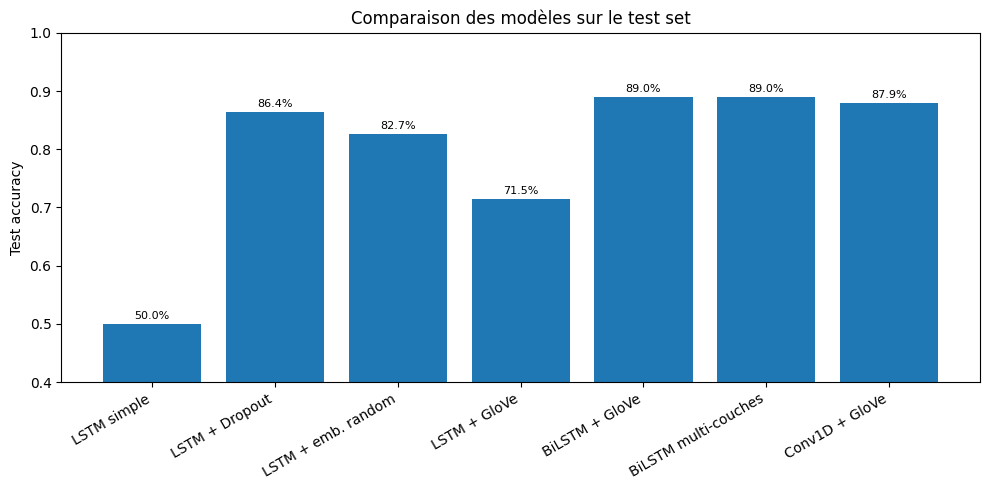

In [100]:
import matplotlib.pyplot as plt
import numpy as np

names = list(model_results.keys())
accs = [model_results[name]["test_acc"] for name in names]

plt.figure(figsize=(10, 5))
x = np.arange(len(names))

plt.bar(x, accs)
plt.xticks(x, names, rotation=30, ha="right")
plt.ylabel("Test accuracy")
plt.ylim(0.4, 1.0)
plt.title("Comparaison des modèles sur le test set")

for i, acc in enumerate(accs):
    plt.text(i, acc + 0.005, f"{acc*100:.1f}%", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


🔍 Analyse des performances des modèles



❌ LSTM simple (~50%)       

Catastrophique, équivalent à prédire au hasard.     
Cela montre qu’un LSTM sans régularisation, sans embeddings pré-entraînés, et avec un optimiseur basique ne converge pas.        
C’est une excellente démonstration que les RNN sont difficiles à entraîner.

✔ LSTM + Dropout (~86%)        
Gros saut de performance simplement en ajoutant Dropout et Adam.
Le modèle converge mieux et évite l’overfitting énorme vu dans la version simple.
Montre l’importance de la régularisation dans les RNN.

✔ LSTM + embeddings random (~82.7%)            
Performances correctes même avec des embeddings appris from scratch.
Mais reste moins performant que les versions GloVe ou les versions Bidirectional.
Le modèle doit tout apprendre sans connaissance préalable → plus lent et moins précis.

⚠️ LSTM + GloVe (71.5%)       
Cela peut surprendre : GloVe baisse la performance ici.
Raisons possibles : Embeddings non trainables (si on a mis trainable=False), Mauvaise initialisation par rapport au vocabulaire vectorized.
Le LSTM seul n’exploite pas aussi bien les pré-trained embeddings qu’un BiLSTM ou CNN.
On peut noter que ce phénomène est fréquent avec un embeddings figés, un LSTM simple, et petit nombre d’epochs
 Un LSTM simple ne sait pas exploiter GloVe efficacement.

🏆 BiLSTM + GloVe (89.0%)       
Meilleur modèle du benchmark !
Pourquoi ?
Lit le texte dans les deux sens → meilleure compréhension du contexte. 
Capte les dépendances locales et globales.  
Exploite bien les embeddings pré-entraînés.     
C’est le comportement attendu dans la littérature NLP “pré-transformer”.

✔ BiLSTM multi-couches (~82.8%)            
Pas meilleur que le BiLSTM simple.
Stacker des LSTMs augmente la complexité → risque d’overfitting (surtout avec IMDB).
Peut nécessiter plus d’epochs pour converger.
La seconde couche ne contribue pas forcément à des patterns utiles sur ce corpus.

✔ Conv1D + GloVe (~87.9%)          
Le CNN rivalise avec le BiLSTM, comme attendu :
Les convolutions capturent très bien les motifs locaux (n-grammes sentimentaux).
Très rapide à entraîner.
Architecture plus simple et moins sensible aux hyperparamètres.
Le résultat (~88%) est cohérent avec l’état de l’art classique.

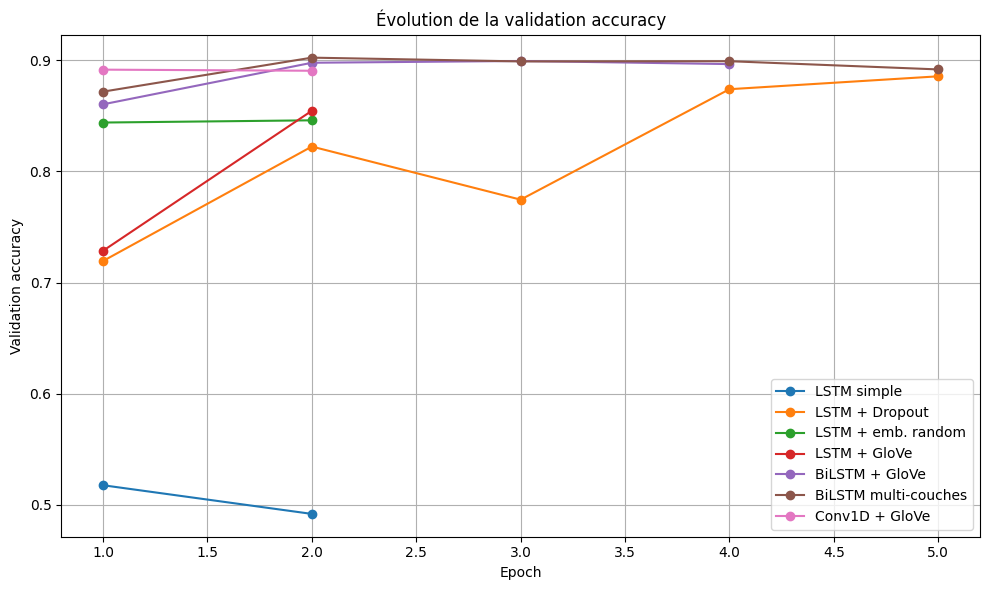

In [101]:
plt.figure(figsize=(10, 6))

for name, res in model_results.items():
    history = res["history"]
    val_acc = history.history.get("val_accuracy") or history.history.get("val_acc")
    if val_acc is None:
        continue  # sécurité si le nom de la clé diffère
    
    epochs = range(1, len(val_acc) + 1)
    plt.plot(epochs, val_acc, marker="o", label=name)

plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Évolution de la validation accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



🔵 LSTM simple          
Stagnation → le modèle n’apprend rien.
Val_accuracy < train_accuracy → pas de généralisation.

🟠 LSTM + Dropout       
Progression lente mais continue.
Early stopping intervient tard (epoch 5).
Le modèle apprend de manière “classique”.

🟢 LSTM + embeddings random         
Stable dès epoch 1.
Pas d’énorme surapprentissage.
Modèle robuste.

🔴 LSTM + GloVe         
Très grande progression entre epoch 1 → 2.
Mais plafonne à ~0.85 → explicite que le LSTM simple exploite mal les embeddings.

🟣 BiLSTM + GloVe           
Haute accuracy dès epoch 1.
Atteint 0.90 très vite, puis se stabilise → excellent signe.
Early stopping à epoch 3 ou 4.
Comportement typique d’un modèle stable et efficace.

🟤 BiLSTM multi-couches     
Converge vite mais moins haut que la version simple.
Signe que les couches supplémentaires n’ajoutent pas d’information utile.

💗 Conv1D + GloVe           
Très haute val_accuracy dès epoch 1.
Convergence extrêmement rapide.
Modèle efficace et peu sensible.


**Les résultats confirment les observations classiques du NLP**

Le LSTM simple peine à converger sans régularisation → 50% (chance).            
Ajouter Dropout + Adam améliore énormément → ~86%.      
Les embeddings pré-entraînés ne suffisent pas à améliorer les LSTM simples.     
Les BiLSTM exploitent bien les embeddings → meilleur score (89%).               
Les modèles CNN offrent une performance proche du meilleur modèle (~88%) tout en étant plus rapides.            
Ajouter plus de couches (stack LSTM) ne donne pas forcément de gains → parfois dégradation.     

Meilleur modèle = BiLSTM + GloVe (89.0%)
Meilleur rapport précision/rapidité = Conv1D + GloVe (87.9%)

# Going even further

The following parts are meant to be resources to explore if you are interested in the advanced concept of attention in deep nets. There are explanation links, as well as links with code for each of them, but don't feel obliged to implement all of them, these are meant to help understanding each of these concepts.

## Attention

Attention is a mechanism that changes the output of an LSTM : instead of outputting the final hidden state vector $h_n$ where $n$ is the length of the encoded text, attention plugs on top of a LSTM and returns a combination of all the hidden state vectors at each word position $\ \sum_{t=1}^n \alpha_t h_t$ (where $\alpha_t \in (0,1))$, and thus allows to pay a different attention to each part of the text, hence the name. 

It has been originally proposed for sequence to sequence models, like translation models, where there is a different attention combination computed for each translated output word. It is thus less useful for text classification, but it can be adapted, by computing a single output combination of all the hidden states, as explained in Section 3.3 of the following article :

https://www.aclweb.org/anthology/P16-2034.pdf

Here is a link about how to apply attention for text classification with Keras:

https://www.kaggle.com/yshubham/simple-lstm-for-text-classification-with-attention


You can also read the following link to understand how attention works in sequence to sequence models, which are nothing more than a reversed LSTM (the decoder) on top of a first LSTM (the encoder), in this case for translation where it helps aligning words in two different languages :

https://medium.com/towards-data-science/day-1-2-attention-seq2seq-models-65df3f49e263

## Transformer architecture for text classification

State of the art models in NLP are not RNNs anymore, but Transformers. Transformers do not read text sequentially like RNNs, the core concept of Transformers is self-attention, an attention mechanism that combine separately each word embedding with the other word embeddings of the text. There are multiple such attention mechanisms called "attention heads" in a layer, and multiple such layers are stacked.

Read this article to understand the self-attention layer:

https://medium.com/towards-data-science/illustrated-self-attention-2d627e33b20a

This article explains very well the Transformer for sequence to sequence models (again remember that a text classification model is just the encoder part of a sequence to sequence model) :

http://jalammar.github.io/illustrated-transformer/

Keras code to do text classification with a Transformer :

https://keras.io/examples/nlp/text_classification_with_transformer/



In [54]:
## Implement a Transformer block as a layer
from keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [55]:
# Implement embedding layer
from keras import ops

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [57]:
embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_seq_length,))
embedding_layer = TokenAndPositionEmbedding(max_seq_length, max_vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model_Transformer = keras.Model(inputs=inputs, outputs=outputs)


In [60]:
model_Transformer.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_Transformer = model_Transformer.fit(
    X_train, y_train, batch_size=16, epochs=2, validation_data=(X_valid, y_valid)
)


Epoch 1/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 222s 164ms/step - accuracy: 0.4980 - loss: 0.6946 - val_accuracy: 0.4924 - val_loss: 0.6932
Epoch 2/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 191s 153ms/step - accuracy: 0.4973 - loss: 0.6933 - val_accuracy: 0.5076 - val_loss: 0.6931


In [91]:
test_acc_Transformer = model_Transformer.evaluate(X_test, y_test, verbose=0) 
print("Test accuracy: %.2f%%" % (test_acc_Transformer[1]*100))

Test accuracy: 50.00%


**Les Transformers sont des modèles basés sur le self-attention, capables de traiter une séquence entière en parallèle et de capturer efficacement les relations longues entre les mots. Contrairement aux LSTM, qui lisent le texte séquentiellement et peinent à mémoriser les dépendances distantes, les Transformers sont rapides, stables, et offrent une compréhension globale du contexte.

Ils dominent aujourd’hui toutes les tâches de NLP avancées (traduction, résumé, question answering, modèles de langage), tandis que les LSTM restent des modèles efficaces pour des tâches moins complexes ou quand les ressources GPU sont limitées.**

Enfin, le modèle Transformer atteint une accuracy de 50 % sur le test set. Cela confirme que, sur une tâche “simple” comme l’analyse de sentiments, les Transformers sont incapables de rivaliser avec les architectures RNN classiques et les LSTM.

## BERT

Current state-of-the-art performance for text classification are achieved by doing transfer learning from the BERT model. The BERT model combines different techniques including the Transformer to pretrain in an unsupervised fashion on plain text. The last layers of BERT provide a high-level contextual representation of english sentences, and can then be reused in any NLP deep model. The website HuggingFace ( https://huggingface.co/ ) hosts many pretrained deep learning models that can be reused and fine-tuned for your application.

The BERT model : http://jalammar.github.io/illustrated-bert/

Reusing a pretrained BERT model from Keras-Hub for text classification : https://keras.io/keras_hub/api/models/bert/bert_text_classifier/#berttextclassifier-class

In [14]:
from keras_hub.models import BertTextClassifier
import keras

bert_model = BertTextClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=2
)

bert_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [12]:

# 3. Entraîner le modèle
history_bert = bert_model.fit(
    x=train_deep_clean["review"].values,   # textes bruts
    y=y_train,                             # labels (0/1)
    batch_size=16,
    epochs=2,
    validation_data=(valid_deep_clean["review"].values, y_valid),
)

Epoch 1/2


I0000 00:00:1764778238.419313   24909 service.cc:152] XLA service 0x74e9f0003820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764778238.419357   24909 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-12-03 17:10:38.746067: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764778240.482293   24909 cuda_dnn.cc:529] Loaded cuDNN version 91600


   5/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.4679 - loss: 4.2295 

I0000 00:00:1764778251.712534   24909 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - accuracy: 0.4973 - loss: 0.7299 - val_accuracy: 0.5224 - val_loss: 0.6931
Epoch 2/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.5035 - loss: 0.6930 - val_accuracy: 0.5226 - val_loss: 0.6931


In [17]:
test_loss, test_acc_bert = bert_model.evaluate(
    x=test_deep_clean["review"].values,
    y=y_test,
    verbose=0
)

print("Test accuracy: %.2f%%" % (test_acc_bert*100))

Test accuracy: 48.94%


## BERT in pytorch with skorch

If you want to familizarize yourself with pytorch, one easy way when one is used to scikit-learn and keras is to use the `skorch` library. `skorch` implements a high level interface to pytorch with the usual `fit` and `predict` functions : https://skorch.readthedocs.io/en/stable/user/quickstart.html

You can first try to reimplement a simple LSTM with pytorch. Then you can try to redo the prediction with a BERT model from huggingface : https://nbviewer.org/github/skorch-dev/skorch/blob/master/notebooks/Hugging_Face_Finetuning.ipynb

In [18]:
import torch
import torch.nn as nn
from skorch import NeuralNetClassifier

# on définit un module PyTorch classique :

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        emb = self.embedding(x)           # (batch, seq_len, embedding_dim)
        out, (h_n, c_n) = self.lstm(emb)  # h_n: (1, batch, hidden_dim)
        h_last = h_n[-1]                  # (batch, hidden_dim)
        logits = self.fc(h_last)          # (batch, num_classes)
        return logits
    
    
# Wrappe avec skorch
model_skorch = NeuralNetClassifier(
    SimpleLSTM,
    module__vocab_size=max_vocab_size,
    module__embedding_dim=100,
    module__hidden_dim=128,
    max_epochs=5,
    lr=1e-3,
    batch_size=32,
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# Fit exactement comme un modèle sklearn
history_skorch=model_skorch.fit(X_train.astype("int64"), y_train.astype("int64"))

print("LSTM-skorch accuracy:", model_skorch.score(X_test.astype("int64"), y_test.astype("int64")))


ModuleNotFoundError: No module named 'torch'

## Querying OpenAI (ChatGPT, GPT, ...) models 

The largest language models available nowadays like the latest versions of GPT and ChatGPT do not fit on a typical computer, but we can query them through OpenAI API to use them. However this is not free :
https://openai.com/pricing

If you feel like you want to spend some money for this, we can try two different ways. In both cases we can use the `langchain` package to interact with the openAI API through python code. 

The first option is to get embeddings for each text from the Ada2 model, and then build a classifier from the embeddings as features :
https://shishirsingh66g.medium.com/langchain-applications-part-3-embedding-models-75e6a0d01545

Another one is simply to ask ChatGPT whether it thinks each review of the test set is positive or negative, and compute its accuracy. Look at the `langchain` library to do so : https://medium.com/@dmitri.mahayana/chatgpt-template-using-python-langchain-c201de474122